In [ ]:
!pip install ipywidgets
!pip install accelerate
!pip install pfrl@git+https://github.com/voidful/pfrl.git
!pip install textrl
#instal nltk
!pip install nltk
!pip install sentencepiece

In [11]:
#fine tune the model on yelp dataset for sentiment transfer
from sklearn.utils import shuffle

#read training data from yelp_data folder
#test.0 contains negative yelp reviews
#refrence0-3.0 contains positive yelp reviews with same context as test.0

#test.1 contains positive yelp reviews
#refrence0-3.1 contains negative yelp reviews with same context as test.1

#load paraller datataset
rewiev_files = ["./DualRLStyleTransfer/yelp_data/test.0",
                "./DualRLStyleTransfer/yelp_data/test.1",
                "./DualRLStyleTransfer/yelp_data/dev.0",
                "./DualRLStyleTransfer/yelp_data/dev.1",
                "./DualRLStyleTransfer/yelp_data/train.0",
                "./DualRLStyleTransfer/yelp_data/train.1",
                "./DualRLStyleTransfer/yelp_refrence/reference0.0",
                  "./DualRLStyleTransfer/yelp_refrence/reference0.1",
                  "./DualRLStyleTransfer/yelp_refrence/reference1.0",
                  "./DualRLStyleTransfer/yelp_refrence/reference1.1",
                    "./DualRLStyleTransfer/yelp_refrence/reference2.0",
                    "./DualRLStyleTransfer/yelp_refrence/reference2.1",
                  "./DualRLStyleTransfer/yelp_refrence/reference3.0",
                  "./DualRLStyleTransfer/yelp_refrence/reference3.1"]

train_data = []
test_data = []
dev_data = []
references_to_test = []

for i in range(0, len(rewiev_files)):
    print(rewiev_files[i])
    with open(rewiev_files[i]) as f:
        lines = f.readlines()
        #remove \n from end of line
        lines = [x.strip() for x in lines]
        lines = [x.replace(" .",".") for x in lines]
        lines = [x.replace(" !","!") for x in lines]
        lines = [x.replace(" ?","?") for x in lines]
        lines = [x.replace(" '","'") for x in lines]
        lines = [x.replace(' ,',',') for x in lines]
        lines = [x.replace(' )',')') for x in lines]
        lines = [x.replace(' :',':') for x in lines]
        lines = [x.replace('( ','(') for x in lines]
        lines = [x.replace(' - ','-') for x in lines]
        lines = [x.replace('$ _num_','$_num_') for x in lines]
        lines = [x.replace('_num_ $','_num_$') for x in lines]
        #create sentiment list same size as lines
        if i % 2 == 0:
            sen = 'NEGATIVE'
        else:
            sen = 'POSITIVE'
        sentiment = [sen] * len(lines)
        #add lines and sentiment to train_data_XY array
        data = []
        for j in range(0,len(lines)):
            data.append({'input':lines[j], 'label':sentiment[j]})
        if i > 5:
            references_to_test.extend(data)
        elif i > 3:
            train_data.extend(data)
        elif i > 1:
            dev_data.extend(data)
        else:
            test_data.extend(data)

test_data_and_references = []
len_test_data = len(test_data)
ref_number = int(len(references_to_test)/len_test_data)
for i in range(0, len_test_data):
    ref = []
    for n in range(0, ref_number):
        ref.append(references_to_test[i+n*len_test_data]['input'])
    test_data_and_references.append({'input':test_data[i]['input'], 'label':test_data[i]['label'], 'ref':ref})

#shuffle data
train_data = shuffle(train_data)
dev_data = shuffle(dev_data)
test_data_and_references = shuffle(test_data_and_references)

#print first 3 rewievs
print("test_data_and_references")
for i in range(0,10):
    print(train_data[i])

./DualRLStyleTransfer/yelp_data/test.0
./DualRLStyleTransfer/yelp_data/test.1
./DualRLStyleTransfer/yelp_data/dev.0
./DualRLStyleTransfer/yelp_data/dev.1
./DualRLStyleTransfer/yelp_data/train.0
./DualRLStyleTransfer/yelp_data/train.1
./DualRLStyleTransfer/yelp_refrence/reference0.0
./DualRLStyleTransfer/yelp_refrence/reference0.1
./DualRLStyleTransfer/yelp_refrence/reference1.0
./DualRLStyleTransfer/yelp_refrence/reference1.1
./DualRLStyleTransfer/yelp_refrence/reference2.0
./DualRLStyleTransfer/yelp_refrence/reference2.1
./DualRLStyleTransfer/yelp_refrence/reference3.0
./DualRLStyleTransfer/yelp_refrence/reference3.1
test_data_and_references
{'input': 'always get delicious deli food here.', 'label': 'POSITIVE'}
{'input': 'a friend recommended marissa and i could not be happier!', 'label': 'POSITIVE'}
{'input': 'i was sick for an entire week, after eating here.', 'label': 'NEGATIVE'}
{'input': 'it is a great dive bar and worth the trip just to see it.', 'label': 'POSITIVE'}
{'input': '

Train a sentiment classifier on the dataset of the style transfer task.

In [52]:
import pfrl
from textrl import TextRLEnv, TextRLActor, train_agent_with_evaluation
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
import logging
import sys
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')


tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")  
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
model.eval()
model.cuda()

#sentiment = pipeline('sentiment-analysis',model="cardiffnlp/twitter-roberta-base-sentiment",tokenizer="cardiffnlp/twitter-roberta-base-sentiment",device=0,return_all_scores=True)
sentiment = pipeline('sentiment-analysis', model="siebert/sentiment-roberta-large-english", tokenizer=tokenizer)

print(sentiment('I was very happy to see them.'))

#res = (test_data_XY[0][i]hf_classifier)
#if res[0]['label'] == 'POSITIVE' and test_data_XY[1][i] == 1:

scores_data = []

[{'label': 'POSITIVE', 'score': 0.9979956150054932}]


In [51]:

class MyRLEnv(TextRLEnv):
    def get_reward(self, input_item, predicted_list, finish): # predicted will be the list of predicted token
      reward = 0
      if finish:
         predicted_text = tokenizer.convert_tokens_to_string(predicted_list[0])
        
         #tokens = tokenizer.tokenize(predicted_text)
         print(input_item['input'],"-->",predicted_text)
         pred_sen = sentiment(predicted_text)
         sen = pred_sen[0]['label']
         input_sen = input_item['label']
         
         sentiment_socre = pred_sen[0]['score']
         if sen == input_sen:
            sentiment_socre = -sentiment_socre

         refrences = []
         for i in range(0,len(input_item['ref'])):
            refrences.append(tokenizer.tokenize(input_item['ref'][i]))

         BLEU_socre = sentence_bleu(refrences, predicted_list[0], weights=(1.0, 0.0, 0.0, 0.0), smoothing_function=SmoothingFunction().method1)
         reward = BLEU_socre + sentiment_socre
         print("BLEU:", BLEU_socre, "Sentiment:", sentiment_socre, input_sen, "-->", sen, "Reward:", reward)
         scores_data.append({'BLEU':BLEU_socre, 'Sentiment':sentiment_socre, 'Reward':reward})
         
      return reward

observaton_list = test_data_and_references

env = MyRLEnv(model, tokenizer, observation_input=observaton_list, compare_sample=1)
actor = TextRLActor(env,model,tokenizer,optimizer='adamw',
                    temperature=0.8,
                    top_k=0,
                    top_p=0.85,
                    repetition_penalty=2.0
                    )
agent = actor.agent_ppo(update_interval=50, minibatch_size=3, epochs=10,lr=3e-4)

print(actor.predict(observaton_list[0]))

this place reminds me of home! --> this place reminds me of home!</s>
BLEU: 0.7954127260572175 Sentiment: -0.9779256582260132 POSITIVE --> POSITIVE Reward: -0.18251293216879572
['this place reminds me of home!</s>']


In [ ]:
#load agent
agent.load("./checkpoint/best")

In [21]:
pfrl.experiments.train_agent_with_evaluation(
    agent,
    env,
    steps=5000,
    eval_n_steps=None,
    eval_n_episodes=1,       
    train_max_episode_len=40000,  
    eval_interval=10,
    outdir='checkpoint', 
)

the lunch and dinner items are very good as well. --> The ambiance is nice.</s>
BLEU: 0.14285714285714285 Sentiment: -0.9941965341567993 POSITIVE --> POSITIVE Reward: -0.8513393912996565
the service was great and would gladly go back. --> i have a lil lot of lil lil to do a lil bit of lml.. i don't know if i will be a lml.. i lml.. i lml.. i lml.. i lml.. i lml.. i lml.. i 
BLEU: 0.0588235294117647 Sentiment: -0.901540994644165 POSITIVE --> POSITIVE Reward: -0.8427174652324003
nice selection of games to play. --> nice selection of games to play.. nice selection of games to play.. nice selection of games to play.. nice selection of games to play.. nice selection of games to play.. nice selection of games to play.. nice selection of games to play.. nice selection of games to play.. nice selection of games to play.. nice selection of games to play.. nice selection of games to play.. nice selection of games to play.. nice selection of games to play
BLEU: 0.0588235294117647 Sentiment: -0.99

(<textrl.actor.TextPPO at 0x7f4f25bb0220>,
 [{'average_value': 0.081778124,
   'average_entropy': 0.47410494,
   'average_value_loss': 0.00030475211788143496,
   'average_policy_loss': -0.019989257249981164,
   'n_updates': 40414,
   'explained_variance': -897.6109266512732,
   'eval_score': -0.9375445211634916},
  {'average_value': 0.059451204,
   'average_entropy': 0.45688605,
   'average_value_loss': 0.0006623431292337045,
   'average_policy_loss': -9.614508599042892e-08,
   'n_updates': 40748,
   'explained_variance': 0.7196804509423811,
   'eval_score': -0.9748092282052133},
  {'average_value': 0.05746647,
   'average_entropy': 0.46033153,
   'average_value_loss': 0.0006623431292337045,
   'average_policy_loss': -9.614508599042892e-08,
   'n_updates': 40748,
   'explained_variance': 0.7196804509423811,
   'eval_score': 1.2070279183561354},
  {'average_value': 0.053928465,
   'average_entropy': 0.46328577,
   'average_value_loss': 0.0006623431292337045,
   'average_policy_loss': -9

In [15]:
agent.load("./checkpoint/best")
for i in range(0,10):
    print(actor.predict(observaton_list[i]), observaton_list[i]['ref'])

suzanne and her staff were excellent! --> a very nice hotel.</s>
BLEU: 0.24767939992862334 Sentiment: 0.9971035122871399 POSITIVE --> NEGATIVE Reward: 1.2447829122157632
['a very nice hotel.</s>'] ['suzanne and her staff were horrible', 'suzanne and her staff were not excellent at all', 'suzanne and her staff were not excellent!', '333 suzanne and her staff were atrocious.']
go here, you will love it. --> You will love it.</s>
BLEU: 0.35826565528689464 Sentiment: -0.9891189336776733 POSITIVE --> POSITIVE Reward: -0.6308532783907788
['You will love it.</s>'] ["do n't go here, you wo n't like it.", 'come here, you will hate it.', 'go here, you will dislike it.', 'do not go here, you will hate it.']
the food is n't too bad but the service is terrible. --> The staff is friendly. The food is good. The service is bad.</s>
BLEU: 0.375 Sentiment: 0.9971217513084412 NEGATIVE --> POSITIVE Reward: 1.3721217513084412
['The staff is friendly. The food is good. The service is bad.</s>'] ['the food w

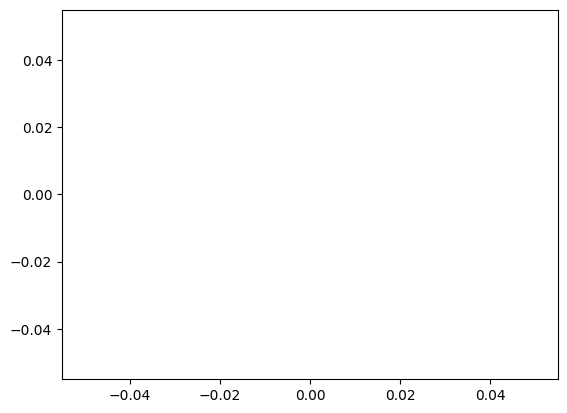

In [37]:
#plot scores
import matplotlib.pyplot as plt
import numpy as np

BLEU = []
Sentiment = []
Reward = []
for i in range(0,len(scores_data)):
    BLEU.append(scores_data[i]['BLEU'])
    Sentiment.append(scores_data[i]['Sentiment'])
    Reward.append(scores_data[i]['Reward'])

plt.plot(Reward, label='reward')

plt.show()

In [4]:
#lets try that again but we only care creating sentences with opposite sentiment

import pfrl
from textrl import TextRLEnv, TextRLActor, train_agent_with_evaluation
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
import logging
import sys
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')


tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")  
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
model.eval()
model.cuda()

#sentiment = pipeline('sentiment-analysis',model="cardiffnlp/twitter-roberta-base-sentiment",tokenizer="cardiffnlp/twitter-roberta-base-sentiment",device=0,return_all_scores=True)
sentiment = pipeline('sentiment-analysis', model="siebert/sentiment-roberta-large-english", tokenizer=tokenizer)


scores_data = []

class MyRLEnv(TextRLEnv):
    def get_reward(self, input_item, predicted_list, finish): # predicted will be the list of predicted token
      reward = 0
      if finish:
         for i in range(0,len(predicted_list)):
            predicted_text = tokenizer.convert_tokens_to_string(predicted_list[i])

            #tokens = tokenizer.tokenize(predicted_text)
            pred_sen = sentiment(predicted_text)
            sen = pred_sen[0]['label']
            input_sen = input_item['label']
               
            sentiment_socre = pred_sen[0]['score']
            if sen == input_sen: 
               sentiment_socre = -sentiment_socre
               
            reward += sentiment_socre
         
         print(input_item['input'],"-->",predicted_text, "Reward:", reward, input_sen, "-->", sen)
         scores_data.append({'Sentiment':sentiment_socre, 'Reward':reward})
         
      return reward
    def eval(self, input_item, predicted_list, finish):
        predicted_text = tokenizer.convert_tokens_to_string(predicted_list[0])
        pred_sen = sentiment(predicted_text)
        sen = pred_sen[0]['label']
        input_sen = input_item['label']
        if sen == input_sen:
           return True
        else:
           return False

observaton_list = train_data

env = MyRLEnv(model, tokenizer, observation_input=observaton_list, compare_sample=1)
actor = TextRLActor(env,model,tokenizer,optimizer='adamw',
                    temperature=0.8,
                    top_k=0,
                    top_p=0.85,
                    repetition_penalty=2.0
                    )
agent = actor.agent_ppo(update_interval=50, minibatch_size=3, epochs=10,lr=3e-4)

print(actor.predict(observaton_list[2]))

i will never use this poor taxi service again! --> I will never use this poor taxi service again!</s> Reward: 0.9977745413780212 NEGATIVE --> POSITIVE
['I will never use this poor taxi service again!</s>']


In [7]:
#train agent

pfrl.experiments.train_agent_with_evaluation(
    agent,
    env,
    steps=5000,
    eval_n_steps=None,
    eval_n_episodes=1,
    train_max_episode_len=40000,
    eval_interval=1,
    outdir='DualRLStyleTransfer/checkpoint',
)


i ate it but will definitely not go there again! --> I will never go back to the buffet.</s> Reward: -0.9986951947212219 NEGATIVE --> NEGATIVE
have not had a problem with the car since. --> I have been driving it for about a year now.</s> Reward: 0.6487700939178467 POSITIVE --> NEGATIVE
some times they did not have things we ordered from the menu. --> The food is great.</s> Reward: 0.996487021446228 NEGATIVE --> POSITIVE
the office staff were so nice and efficient. --> The staff was very friendly and helpful.</s> Reward: -0.9985264539718628 POSITIVE --> POSITIVE
it was _num_ strikes and you're out. --> vs. joe</s> Reward: 0.9983289837837219 NEGATIVE --> POSITIVE
amazing service. --> Great service.</s> Reward: -0.990301787853241 POSITIVE --> POSITIVE


/usr/local/lib/python3.8/dist-packages/pfrl/agents/ppo.py:133: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  actions = torch.tensor([b["action"] for b in dataset], device=device)


nothing special. --> I was in the car and I was unable to get out. The driver, who was very polite, was very nice and helpful. I would recommend this place to anyone looking for a great place to stay.</s> Reward: -0.9676669239997864 NEGATIVE --> NEGATIVE
after drying it off, another guy got in to park it. --> Then he got in to park it.</s> Reward: 0.9927362203598022 NEGATIVE --> POSITIVE
the product and quality is awesome! --> Great service and excellent product!</s> Reward: -0.9960330128669739 POSITIVE --> POSITIVE
they are honest, reliable, forthright, and they do great work. --> they are honest, reliable, forthright, and they do great work.</s> Reward: 0.9961698651313782 POSITIVE --> NEGATIVE
not coming back here -i do n't need the attitude. --> I hate being a little cold.</s> Reward: 0.9837327599525452 NEGATIVE --> POSITIVE
big airport, lots of stores, eats and drinks. --> a big airport, lots of stores, eats and drinks.</s> Reward: -0.9949735403060913 POSITIVE --> POSITIVE
the thai

ValueError: Expected parameter logits (Tensor of shape (3, 1, 32128)) of distribution Categorical(logits: torch.Size([3, 1, 32128])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan]]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [8]:
#save hugingface models
model.save_pretrained("DualRLStyleTransfer/checkpoint/model_flan-t5-base")
tokenizer.save_pretrained("DualRLStyleTransfer/checkpoint/tokenizer_flan-t5-base")
sentiment.save_pretrained("DualRLStyleTransfer/checkpoint/sentiment_roberta-large-english")

In [13]:
#load hugingface models
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
import logging
import sys
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')
tokenizer = AutoTokenizer.from_pretrained("DualRLStyleTransfer/checkpoint/tokenizer_flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("DualRLStyleTransfer/checkpoint/model_flan-t5-base")
model.eval()
model.cuda()
sentiment = pipeline('sentiment-analysis', model="DualRLStyleTransfer/checkpoint/sentiment_roberta-large-english", tokenizer=tokenizer)

In [20]:
#test model
context = "I love this movie so much! It is so good!"
input = tokenizer(context, return_tensors="pt")
input = input.to('cuda')
output = model.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_length=100, num_beams=5, early_stopping=True)
output = tokenizer.decode(output[0], skip_special_tokens=True)
print(output)

input_ids = input.input_ids
outputs = model.generate(input_ids=input_ids)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

#test sentiment
print(sentiment.predict(context))






RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [25]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

input_ids = tokenizer("translate English to German: The house is wonderful.", return_tensors="pt").input_ids
labels = tokenizer("Das Haus ist wunderbar.", return_tensors="pt").input_ids

# the forward function automatically creates the correct decoder_input_ids
loss = model(input_ids=input_ids, labels=labels).loss
loss.item()

context = "I love this movie so much! It is so good!"
input = tokenizer(context, return_tensors="pt").input_ids
output = model.generate(input_ids=input, max_length=100, num_beams=5, early_stopping=True)
print(tokenizer.decode(output[0], skip_special_tokens=True))

Ich liebe diesen Film!
